### Exploration of Stringer Dataset - Analysis of SVD components and Neural activity

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from umap import UMAP

In [2]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [3]:
# 1. Examine the structure of behavioral SVDs
n_svd_components = dat['beh_svd_time'].shape[1]
n_timepoints = dat['beh_svd_time'].shape[0]
mask_shape = dat['beh_svd_mask'].shape[:2]

print(f"Number of SVD components: {n_svd_components}")
print(f"Number of timepoints: {n_timepoints}")
print(f"Mask shape: {mask_shape}")

Number of SVD components: 1000
Number of timepoints: 7018
Mask shape: (240, 320)


## SVD matrices

SVD (Singular Value Decomposition) components, in the context of the facial movement data are a way of breaking down complex facial movements into simpler, fundamental patterns. This makes it easier to analyze how these movements relate to neural activity and other behaviors, by focusing on these core patterns rather than trying to analyze every pixel of movement independently.

Each component has a corresponding time course that shows how strongly that particular movement pattern is expressed at each moment during the experiment.

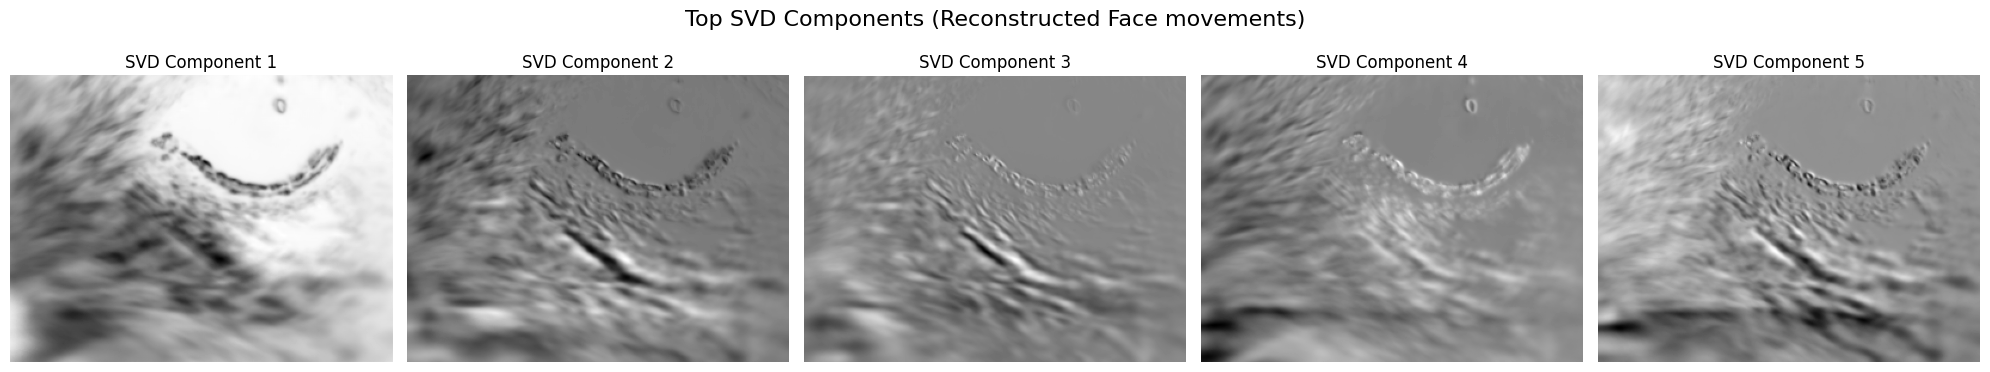

In [30]:
# 2. Visualize top SVD components
n_top_components = 5
fig, axs = plt.subplots(1, n_top_components, figsize=(20, 4))
fig.suptitle('Top SVD Components (Reconstructed Face movements)', fontsize=16)
for i in range(n_top_components):
    axs[i].imshow(dat['beh_svd_mask'][:,:,i], cmap='gray')
    axs[i].set_title(f'SVD Component {i+1}')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

## Time courses of the components

The time courses of the components are shown below. The x-axis represents time, and the y-axis represents the Shows the component strength, which indicates how strongly each facial movement pattern is expressed at any given time.

Inference:

- Facial movements are complex and constantly changing throughout the experiment.
- There's one dominant movement pattern (Component 1) and several secondary patterns.
- The rapid fluctuations suggest the animal's face is very active, possibly indicating high engagement or responsiveness during the experiment.
- The consistent activity across all components throughout the experiment suggests the animal remained engaged for its duration.



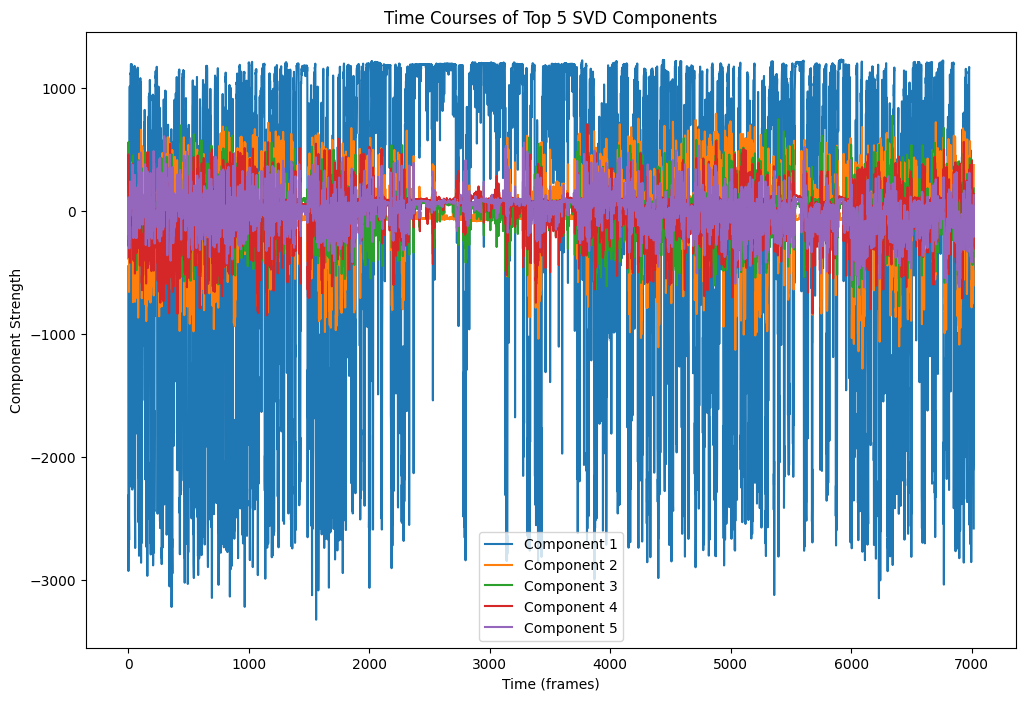

In [7]:
# 3. Plot time courses of top SVD components
plt.figure(figsize=(12, 8))
for i in range(n_top_components):
    plt.plot(dat['beh_svd_time'][:, i], label=f'Component {i+1}')
plt.xlabel('Time (frames)')
plt.ylabel('Component Strength')
plt.title('Time Courses of Top 5 SVD Components')
plt.legend()
plt.show();

## Reconstructed Facial movement patterns 


- Facial Structure:

    + The curved line near the top of each image likely represents the eye or eye area.
    + The area below this might correspond to whiskers, snout, or mouth regions.

- Movement Patterns (motion energy):
    + Brighter colors (yellow/green) indicate areas of higher movement or activity.
    + Darker colors (blue/purple) represent areas with less movement.


- Interpretation:

    + Timepoint 1000 & 3000: The animal might be highly alert or engaged, with significant facial movement.
    + Timepoint 2000: The animal could be more relaxed or less active.
    + Timepoint 4000: Shows focused activity in specific areas, possibly indicating a particular behavior or response.



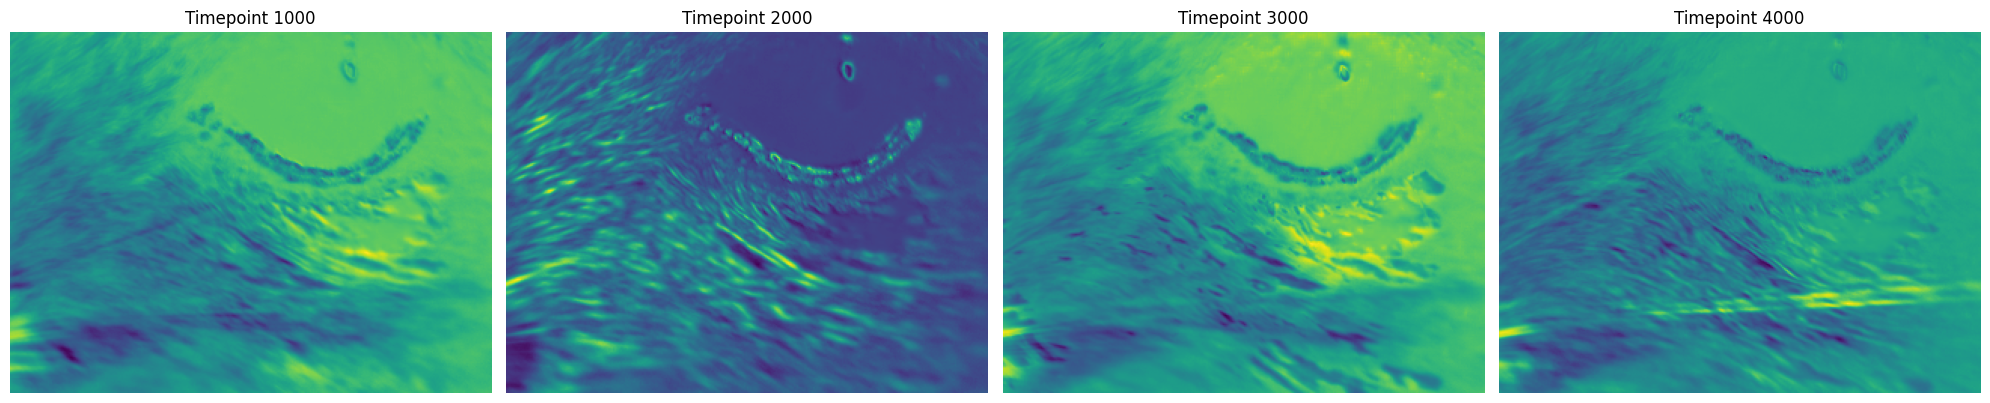

In [10]:
# 4. Reconstruct facial movement at different timepoints
timepoints = [1000, 2000, 3000, 4000]  # Example timepoints
fig, axs = plt.subplots(1, len(timepoints), figsize=(20, 5))
for i, t in enumerate(timepoints):
    reconstructed = dat['beh_svd_mask'] @ dat['beh_svd_time'][t, :]
    axs[i].imshow(reconstructed, cmap='viridis')
    axs[i].set_title(f'Timepoint {t}')
    axs[i].axis('off')
plt.tight_layout()
plt.show();

## Correlation between SVD components and mean neural activity

- Interpretation of correlation values:

    + Positive values indicate that as the strength of that facial movement component increases, neural activity tends to increase.
    + Negative values suggest that as the facial movement component increases, neural activity tends to decrease.
    + Values close to zero indicate little to no linear relationship between that facial movement component and neural activity.

- Inference:
    + Only a small number of facial movement patterns (early SVD components) have a notable relationship with overall neural activity.
    + Most facial movements (later components) have little direct relationship with overall neural activity.
    + The relationship between facial movements and neural activity is complex, with some movements associated with increased activity and others with decreased activity.

Of course correlations doesn't mean causation and also its mean neural activity, so it might miss relationships between facial movements and specific subsets of neurons.

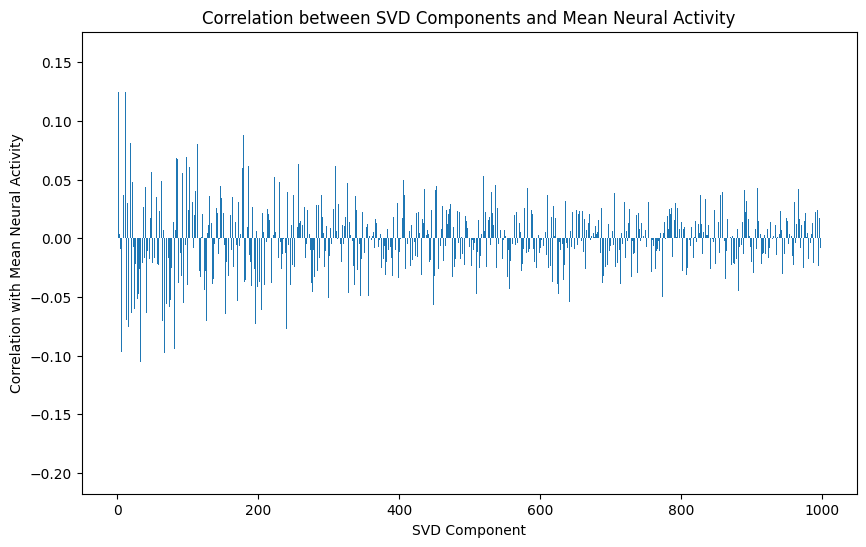

In [11]:
# 5. Correlate SVD components with neural activity
neural_data = dat['sresp']
mean_neural_activity = np.mean(neural_data, axis=0)

svd_neural_corr = np.array([np.corrcoef(mean_neural_activity, dat['beh_svd_time'][:, i])[0, 1] 
                            for i in range(n_svd_components)])

plt.figure(figsize=(10, 6))
plt.bar(range(n_svd_components), svd_neural_corr)
plt.xlabel('SVD Component')
plt.ylabel('Correlation with Mean Neural Activity')
plt.title('Correlation between SVD Components and Mean Neural Activity')
plt.show()

## Behavorial correlations with SVD components

- Overall Pattern:

    + Most components cluster around the center, indicating weak correlations with both behaviors.
    + There's a slight positive trend, suggesting that components positively correlated with running speed tend to be positively correlated with pupil area, and vice versa.

- Interpretation (possible states):
    + SVD 1 might represent a facial expression associated with low arousal or rest (smaller pupils, less running).
    + SVD 2 could be related to a focused state (less running, but not necessarily with pupil dilation).
    + SVD 3, being near the center, might be unrelated to these specific behaviors.
    + SVD 4 might represent an active, alert state (more running, larger pupils).
    + SVD 5 could indicate a state of reduced activity but not as strongly as SVD 1.


Once again take it with a grain of salt, correlations doesn't imply causation. This analysis doesn't account for potential time lags between facial expressions and behaviors.

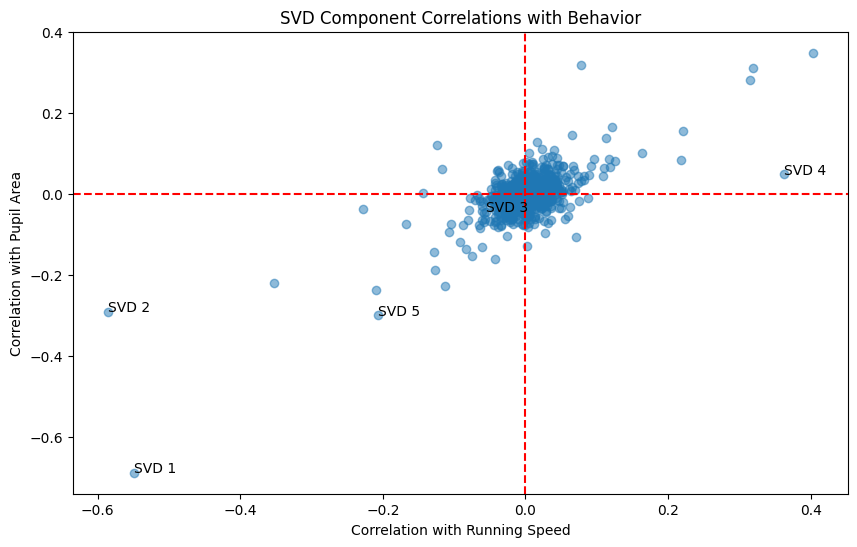

In [12]:
# 6. Relate SVD components to running speed and pupil area
running_speed = dat['run'].flatten()
pupil_area = dat['pupilArea'].flatten()

svd_run_corr = np.array([np.corrcoef(running_speed, dat['beh_svd_time'][:, i])[0, 1] 
                         for i in range(n_svd_components)])
svd_pupil_corr = np.array([np.corrcoef(pupil_area, dat['beh_svd_time'][:, i])[0, 1] 
                           for i in range(n_svd_components)])

plt.figure(figsize=(10, 6))
plt.scatter(svd_run_corr, svd_pupil_corr, alpha=0.5)
plt.xlabel('Correlation with Running Speed')
plt.ylabel('Correlation with Pupil Area')
plt.title('SVD Component Correlations with Behavior')
for i in range(n_top_components):
    plt.annotate(f'SVD {i+1}', (svd_run_corr[i], svd_pupil_corr[i]))
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.show();

## Neural activity and Face movements colored running speed

UMAP has reduced the high-dimensional data of neural activity and facial movements into a 2D representation. Each point represents a moment in time during the experiment. The color of each point represents the running speed at that moment, with the scale on the right showing that purple represents low speed and yellow represents high speed. 

Structure: The plot shows a clear structure with several distinct clusters or regions, suggesting that there are different states or modes of neural activity and facial movement.

- Key inferences:

    + Most of the plot is dominated by purple points, suggesting that the animal was stationary or moving slowly for a large portion of the experiment.
    +   Running seems to be associated with a specific and distinct pattern of neural activity and facial movements.
    +   There are multiple states or patterns of neural activity and facial movements when the animal is not running, suggesting complex behaviors or cognitive states even during low physical activity.
    +   The transition from low to high running speed appears to be associated with a gradual change in neural activity and facial movements, as seen in the color gradient in the lower-left cluster. 


/Users/biswanathsaha/miniconda3/envs/datascience/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


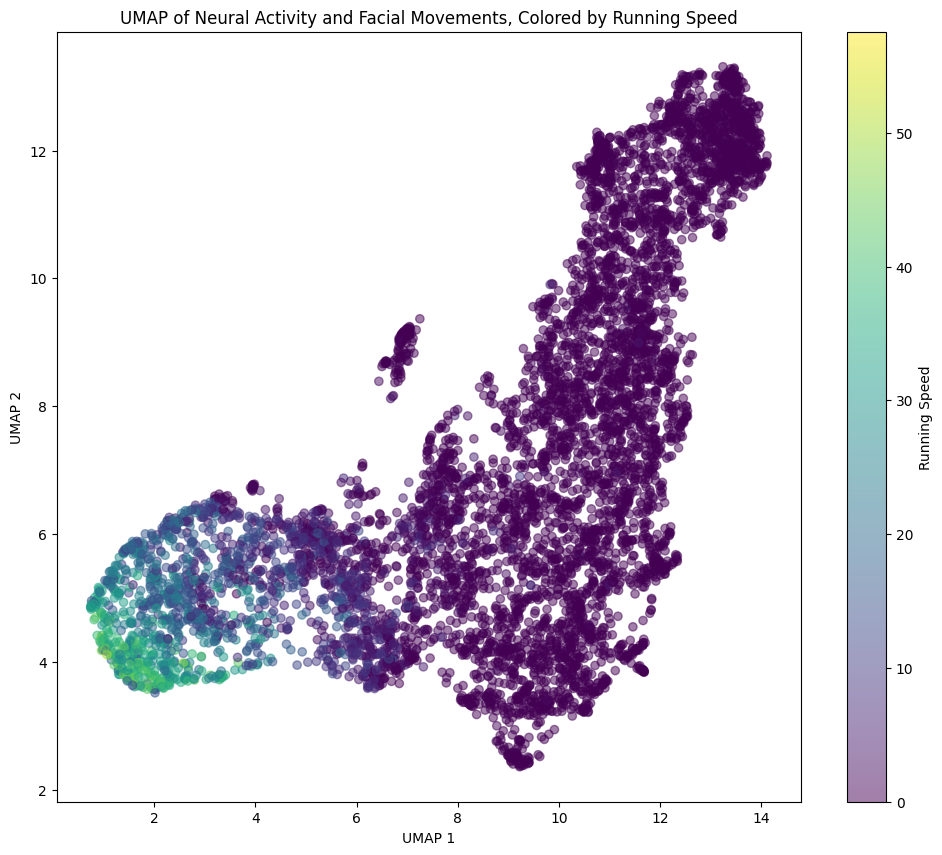

In [13]:
# 7. Dimensionality reduction of neural data with behavioral context
pca = PCA(n_components=50)
neural_pca = pca.fit_transform(neural_data.T)

behavior_context = np.column_stack([neural_pca, dat['beh_svd_time']])

umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_result = umap.fit_transform(behavior_context)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], 
                      c=running_speed, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Running Speed')
plt.title('UMAP of Neural Activity and Facial Movements, Colored by Running Speed')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show();

In [15]:
print(f"Shape of beh_svd_mask: {dat['beh_svd_mask'].shape}")
print(f"Shape of beh_svd_time: {dat['beh_svd_time'].shape}")

Shape of beh_svd_mask: (240, 320, 1000)
Shape of beh_svd_time: (7018, 1000)


In [16]:
# Calculate mean neural activity and find high activity frames
mean_neural_activity = np.mean(dat['sresp'], axis=0)
high_activity_threshold = np.percentile(mean_neural_activity, 90)
high_activity_frames = np.where(mean_neural_activity > high_activity_threshold)[0]

In [17]:
# Calculate average facial movement during high neural activity
avg_high_activity_svd = np.mean(dat['beh_svd_time'][high_activity_frames, :], axis=0)
avg_high_activity_face = dat['beh_svd_mask'] @ avg_high_activity_svd

In [18]:
print(f"Shape of avg_high_activity_face: {avg_high_activity_face.shape}")

Shape of avg_high_activity_face: (240, 320)


## Reconstruct average face movement during high neural activity

- Interpretation:

    + The left side of the image shows more intense activity (greener and some yellow spots), which might correspond to areas of the face with more movement, possibly the mouth and jaw area.
    + The darker purple areas likely indicate regions with minimal movement.
    + The pattern of movement is not uniform, with streaks and patches of varying intensity throughout, suggesting complex patterns of facial muscle activation.
    


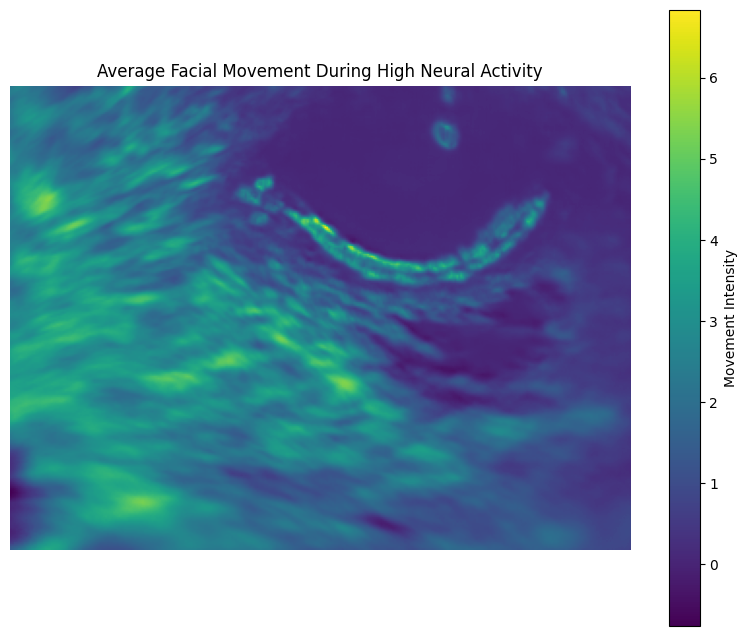

In [32]:
# Visualize average facial movement during high neural activity
plt.figure(figsize=(10, 8))
plt.imshow(avg_high_activity_face, cmap='viridis')
plt.title('Average Facial Movement During High Neural Activity')
plt.colorbar(label='Movement Intensity')
plt.axis('off')
plt.savefig('high_neural_activity_face.png')
plt.show();

## Movement distribution in average face movement during high neural activity

- Interpretation:

    + A large number of points show very little movement (the high peak near 0)
    + There's a wide range of movement intensities, with a concentration of moderate movement around 2-3
    + High-intensity movements (4-6) are less common but still present
    + The bimodal shape might indicate two distinct types of facial movements or expressions captured in the data

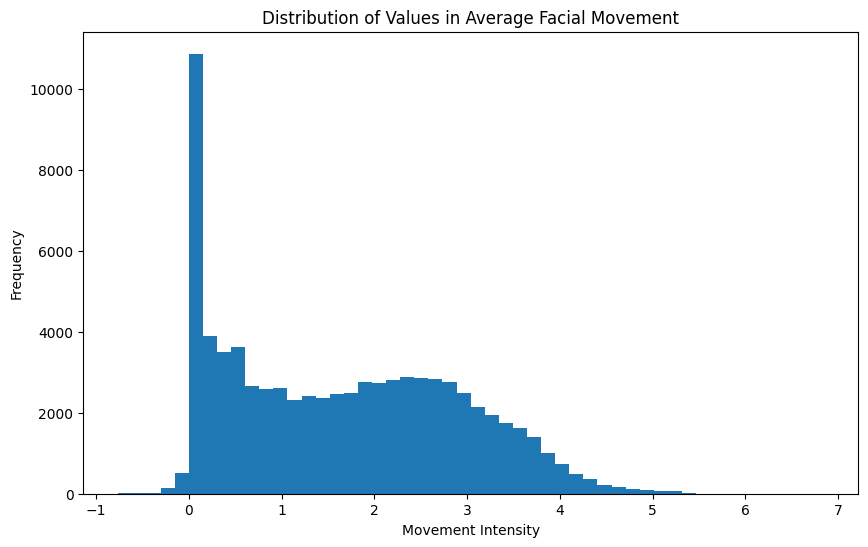

In [22]:
# Let's also look at the distribution of values in avg_high_activity_face
plt.figure(figsize=(10, 6))
plt.hist(avg_high_activity_face.flatten(), bins=50)
plt.title('Distribution of Values in Average Facial Movement')
plt.xlabel('Movement Intensity')
plt.ylabel('Frequency')
plt.show()

##  Frames of high neural activity

- Changes across frames:

    + Frame 7: Shows a baseline of activity.
    + Frame 39: Increased activity in the lower left area, possibly corresponding to the mouth or jaw.
    + Frame 82: The activity in the lower left intensifies and spreads.
    + Frame 88: The intense activity area in the lower left becomes more defined.
    + Frame 112: The activity pattern changes, with some reduction in the lower left and increases in other areas.

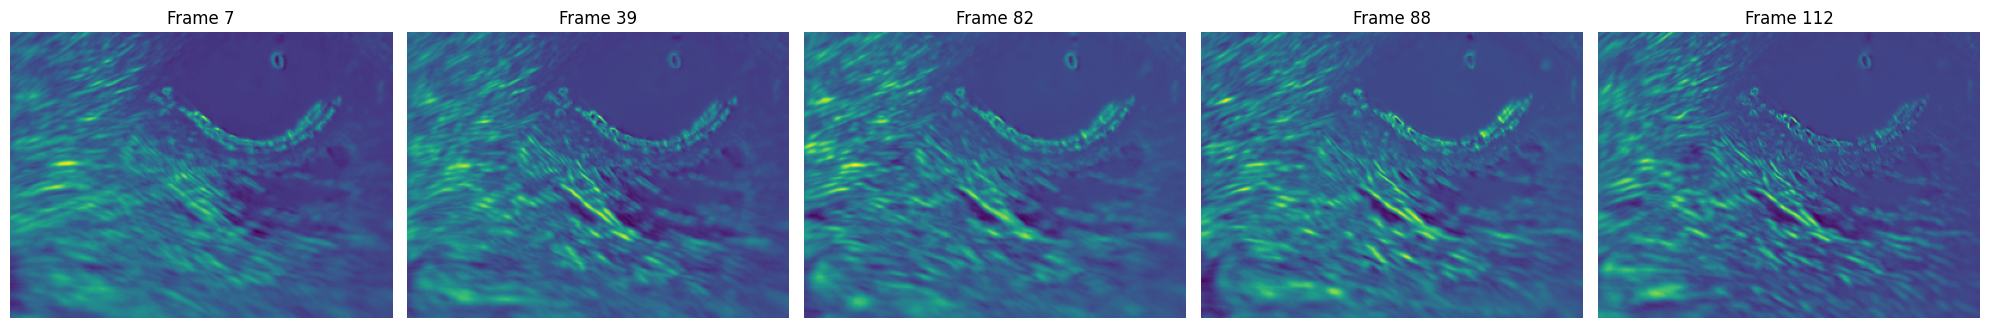

In [23]:
# Visualize a few individual frames of high activity
n_frames = min(5, len(high_activity_frames))
fig, axs = plt.subplots(1, n_frames, figsize=(4*n_frames, 4))
for i in range(n_frames):
    frame = dat['beh_svd_mask'] @ dat['beh_svd_time'][high_activity_frames[i], :]
    axs[i].imshow(frame, cmap='viridis')
    axs[i].set_title(f'Frame {high_activity_frames[i]}')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

In [24]:
from matplotlib.animation import FuncAnimation

In [31]:
## Run this to generate a movie of high neural activity frames

In [27]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))
plt.close()  # Prevent display of the empty figure

# Initialize with the first frame
initial_frame = dat['beh_svd_mask'] @ dat['beh_svd_time'][high_activity_frames[0], :]
im = ax.imshow(initial_frame, cmap='viridis', animated=True)
title = ax.text(0.5, 1.05, "", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
                transform=ax.transAxes, ha="center")
fig.colorbar(im, label='Movement Intensity')

# Update function for animation
def update(frame):
    current_frame = dat['beh_svd_mask'] @ dat['beh_svd_time'][high_activity_frames[frame], :]
    im.set_array(current_frame)
    title.set_text(f'Frame {high_activity_frames[frame]} (High Activity)')
    return im, title

# Create the animation
anim = FuncAnimation(fig, update, frames=min(100, len(high_activity_frames)), 
                     interval=200, blit=True)

anim.save('high_activity_facial_movements.gif', writer='pillow', fps=5)